In [23]:
from glob import glob as gb
import sys


sys.argv = ["", # empty space to account for script
            "/the/path/to/R9_R10/manuscript_code/files/", #base path to where everthing is for this project is stored
            "method_1/*", # rest of path for the method 1 data
            "method_2/*", # rest of path for the method 2 data 
            "org_method/*"] # rest of path for the original data  

base_path = sys.argv[1]
method1_path = sys.argv[2]
method2_path = sys.argv[3]
org_path = sys.argv[4]

path1 = base_path + method1_path
path2 = base_path + method2_path
path3 = base_path + org_path
files1 = gb(path1)
files2 = gb(path2)
files3 = gb(path3)
f = [files1, files2, files3]

<Figure size 500x500 with 0 Axes>

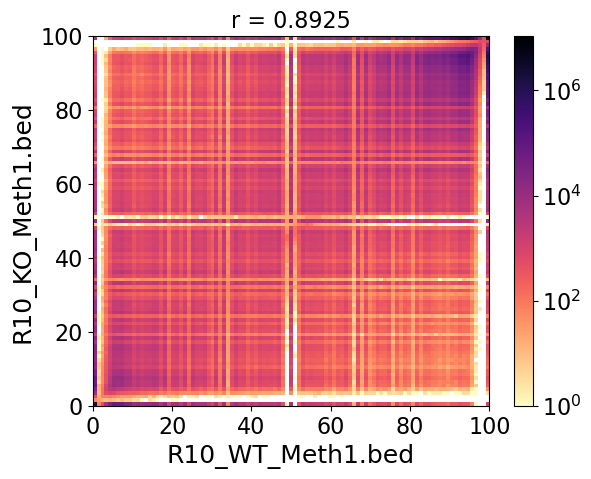

<Figure size 500x500 with 0 Axes>

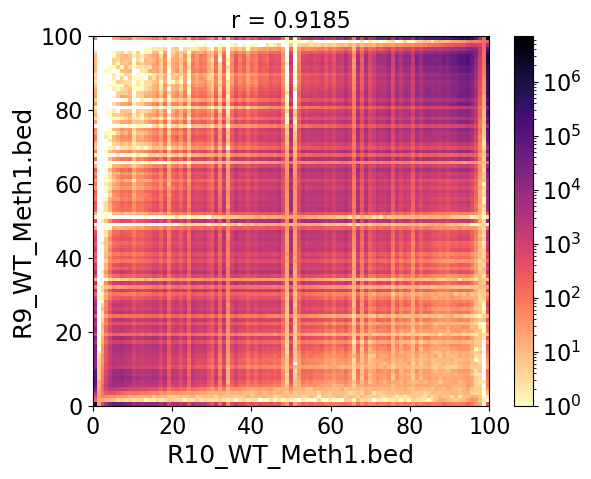

<Figure size 500x500 with 0 Axes>

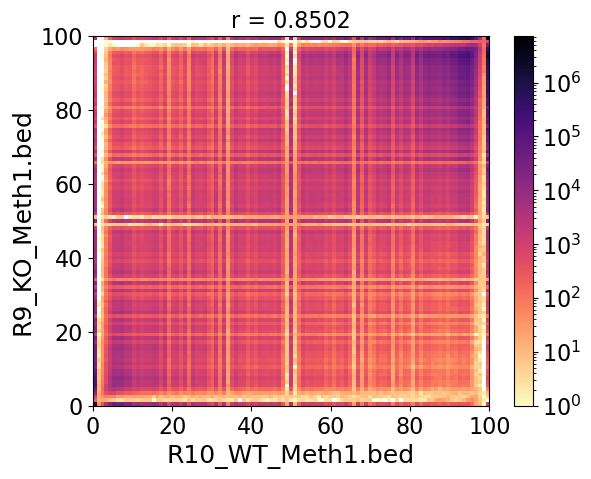

<Figure size 500x500 with 0 Axes>

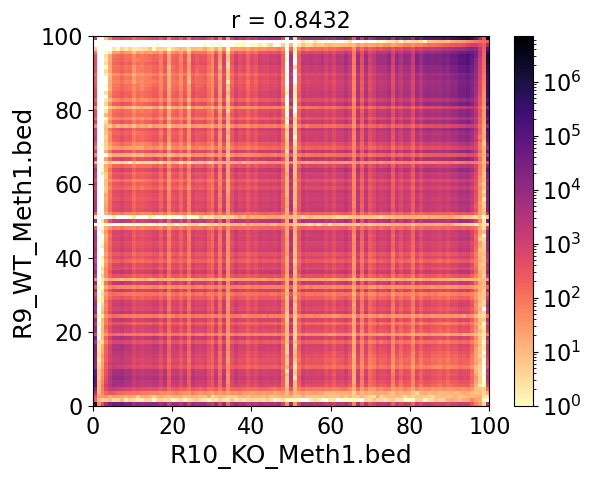

<Figure size 500x500 with 0 Axes>

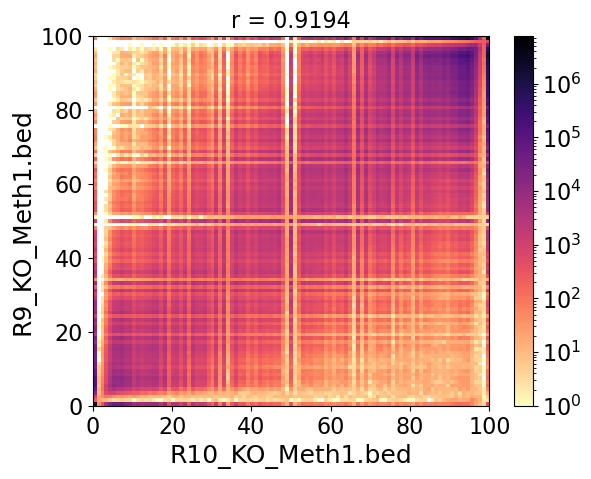

<Figure size 500x500 with 0 Axes>

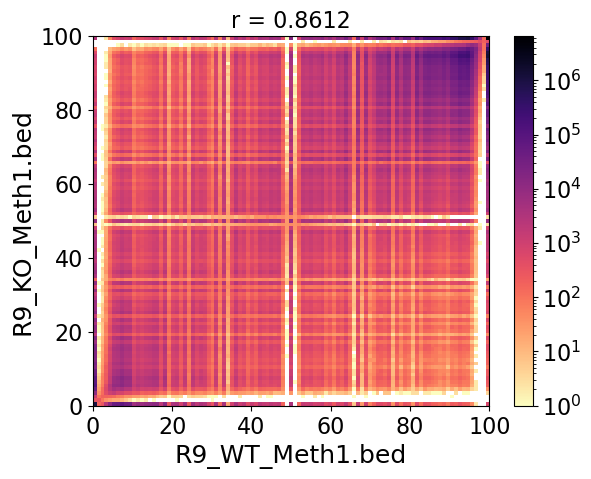

In [9]:
# Figure 2

import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import numpy as np
import itertools
import os.path as os
from scipy.stats import pearsonr


method = 1 #Toggle this to 2 to do the other method
min_coverage = 10
log_norm = "yes"

files = f[method-1]

for f1, f2 in (itertools.combinations(files, 2)):
    # BED file 1
    df1 = pl.read_csv(f1, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_left", "STR_Percentage_left"], has_header=False)
    # BED file 2
    df2 = pl.read_csv(f2, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_right", "STR_Percentage_right"], has_header=False)
    # Merge BED files
    df = df1.join(df2, on=["chr", "start", "end"], how="inner")
    del df1
    del df2
    #Filter for min_coverage parameter
    df = df.filter((pl.col("Coverage_left") > min_coverage) & (pl.col("Coverage_right") > min_coverage))
    for TYPE in ["Percentage"]:
        loop_df = df
        if TYPE == "Percentage":
            # set all NaNs to 0
            loop_df = loop_df.select(pl.col("chr"), pl.col("start"), pl.col("end"), (pl.col("STR_Percentage_left").str.replace(r"(?i)nan", "0")), (pl.col("STR_Percentage_right").str.replace(r"(?i)nan", "0")))
            loop_df = loop_df.select([pl.col("chr"), pl.col("start"), pl.col("end"), pl.col("STR_Percentage_left").cast(pl.Float64).alias("Percentage_left"), pl.col("STR_Percentage_right").cast(pl.Float64).alias("Percentage_right")])
        x = loop_df["Percentage_left"]
        y = loop_df["Percentage_right"]
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots()
        # change log_norm variable to determine heatmap type
        if log_norm == "yes":
            h_ = ax.hist2d(x, y, norm=mpl.colors.LogNorm(), density=False, bins=101, cmap="magma_r")
            cbar = fig.colorbar(h_[3], ax=ax)
        else:
            h = ax.hist2d(x, y, density=False, bins=20, cmap="magma_r")
            cbar = fig.colorbar(h[3], ax=ax)
        cbar.ax.tick_params(labelsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        x = x.to_numpy()
        y = y.to_numpy()
        p_corr = (str(pearsonr(x, y)[0]))
        plt.title("r = " + p_corr[0:6], fontsize=16)
        plt.xlabel(os.basename(f1), fontsize=18)
        plt.ylabel(os.basename(f2), fontsize=18)
        plt.show()
        plt.close()

In [27]:
# Chemistry specific methylation bias 

import os.path as os
import pandas as pd
import numpy as np
import itertools


method = 1 #Toggle this to 2 to do the other method
min_coverage = 10

files = f[method-1]

for f1, f2 in (itertools.combinations(files, 2)):
    # BED file 1
    df1 = pl.read_csv(f1, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_left", "STR_Percentage_left"], has_header=False)
    # BED file 2
    df2 = pl.read_csv(f2, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_right", "STR_Percentage_right"], has_header=False)
    # Merge BED files
    df = df1.join(df2, on = ["chr", "start", "end"], how="inner")
    del df1
    del df2
    #Filter for min_coverage parameter
    df = df.filter((pl.col("Coverage_left") > min_coverage) & (pl.col("Coverage_right") > min_coverage))
    for TYPE in ["Percentage"]:
        loop_df = df
        if TYPE == "Percentage":
            # set all NaNs to 0
            loop_df = loop_df.select(pl.col("chr"), pl.col("start"), pl.col("end"), (pl.col("STR_Percentage_left").str.replace(r"(?i)nan", "0")), (pl.col("STR_Percentage_right").str.replace(r"(?i)nan", "0")))
            loop_df = loop_df.select([pl.col("chr"), pl.col("start"), pl.col("end"), pl.col("STR_Percentage_left").cast(pl.Float64).alias(os.basename(f1)), pl.col("STR_Percentage_right").cast(pl.Float64).alias(os.basename(f2))])
            a = loop_df[os.basename(f1)]
            b = loop_df[os.basename(f2)]
            # Calculating methylation difference
            diff = (a - b)
            diff = diff.rename("diff")
            loop_df.insert_column(2, diff)
            # Checking to see if it is a sample-wise comparison
            if "WT" in f1 and "WT" in f2:
                # R10-preferred sites have a different of -30 % 
                R10_df = loop_df.filter(pl.col('diff') <= -30)
                # R9-preferred sites have a different of 30 %
                R9_df = loop_df.filter(pl.col('diff') >= 30)
                !mkdir -p ./diff_30
                R10_df.write_csv("./diff_30/R10_WT.tsv", separator='\t', include_header=True)
                R9_df.write_csv("./diff_30/R9_WT.tsv", separator='\t', include_header=True)
            elif "KO" in f1 and "KO" in f2:
                # R10-preferred sites have a different of -30 % 
                R10_df = loop_df.filter(pl.col('diff') <= -30)
                # R9-preferred sites have a different of 30 %
                R9_df = loop_df.filter(pl.col('diff') >= 30)
                !mkdir -p ./diff_30
                R10_df.write_csv("./diff_30/R10_KO.tsv", separator='\t', include_header=True)
                R9_df.write_csv("./diff_30/R9_KO.tsv", separator='\t', include_header=True)
        
!grep -T -r . diff_30/R10_*.tsv | sort -k 2 | cut -f 1,2,3 | uniq -D -f 1 > diff_30/R10_overlap.txt
!grep -T -r . diff_30/R9_*.tsv | sort -k 2 | cut -f 1,2,3 | uniq -D -f 1 > diff_30/R9_overlap.txt
!grep -v "start" diff_30/R9_overlap.txt > diff_30/R9_overlap.txt
!grep -v "start" diff_30/R10_overlap.txt > diff_30/R10_overlap.txt

for version in ["R9", "R10"]:
    in_file = pd.read_csv(f"diff_30/{version}_overlap.txt", sep="\t", names=["file","chromosome","position"])
    df = pd.read_csv("./outfile_w_hm450.bed", sep="\t", usecols=[0,1,4], names=["chromosome","position","info_string"])
    in_file['position'] = in_file['position'].astype(int)
    df['position'] = df['position'].astype(int)
    out = in_file.merge(df, how="left", on=["chromosome", "position"])
    out.dropna().to_csv(f"diff_30/{version}_overlap.csv", index=False)

# Overlap of R10 preferred sites
!tail -n +2 diff_30/R10_overlap.csv | wc -l | awk '{print $1 / 2}'
# Number of those which are repeats
!grep REPEAT diff_30/R10_overlap.csv | wc -l | awk '{print $1 / 2}'
# Overlap of R9 preferred sites
!tail -n +2 diff_30/R9_overlap.csv | wc -l | awk '{print $1 / 2}'
# Number of those which are repeats
!grep REPEAT diff_30/R9_overlap.csv | wc -l | awk '{print $1 / 2}'

33215
13496
58753
30232


<Figure size 500x500 with 0 Axes>

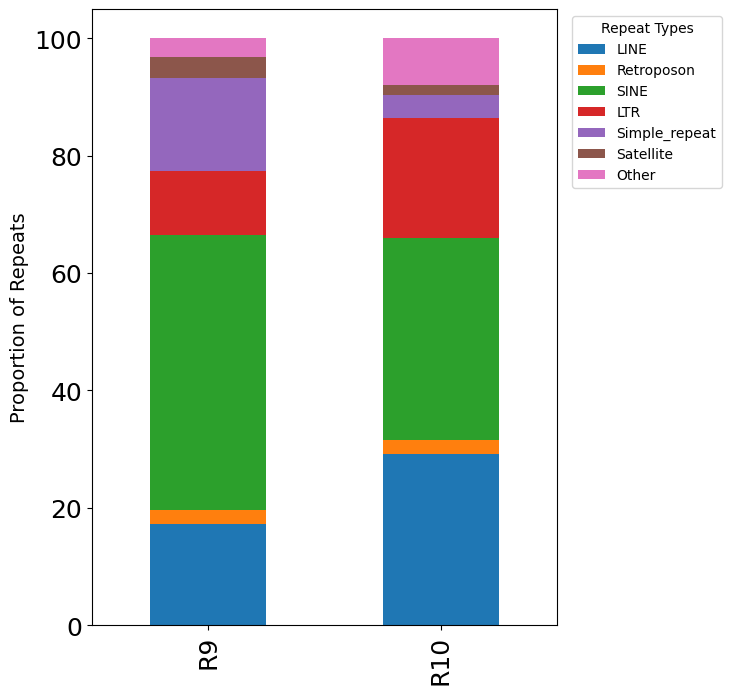

In [28]:
# Figure 3

import matplotlib.pyplot as plt
import pandas as pd


def get_repeat(f):
    with open(f, "r") as fh:
        d = {}
        lines = fh.readlines()
        for line in lines:
            if "REPEAT:" in line:
                rep = line.strip().split("REPEAT:")[-1]
                if '/' in rep:
                    rep_ = rep.split('/')[0]
                    if rep_ not in d:
                        d[rep_] = 1
                    else:
                        d[rep_] += 1 
                else:
                    if rep not in d:
                        d[rep] = 1
                    else:
                        d[rep] += 1
        return d

def drop_low(_res):
    _df = pd.DataFrame.from_dict(_res, orient = 'index')
    hi_df = _df[_df[0] > 260]
    other = _df[_df[0] < 200][0].sum()
    dna_num = hi_df.loc["DNA", : 1]
    other = other + dna_num
    _df = pd.concat([hi_df, pd.DataFrame({0: other[0]}, index = ["Other"])])
    _df = _df.drop("DNA")
    return _df

# Extracting Repeat sites
!grep REPEAT diff_30/R10_overlap.csv > ./diff_30/R10_overlap_repeat.csv
!grep REPEAT diff_30/R9_overlap.csv > ./diff_30/R9_overlap_repeat.csv

# Counting Repeat Types
R9_res = get_repeat("./diff_30/R9_overlap_repeat.csv")
R10_res = get_repeat("./diff_30/R10_overlap_repeat.csv")

R9_df = drop_low(R9_res)
R10_df = drop_low(R10_res)

# Plotting Figure
plt.figure(figsize=(5, 5))
plot_df = pd.concat([((R9_df / R9_df.sum()) * 100), ((R10_df / R10_df.sum()) * 100)], axis = 1) # Proportion of Repeats
# plot_df = pd.concat([R9_df/2, R10_df/2], axis = 1) # Raw counts of Repeats
plot_df.columns = ['R9', 'R10']
plot_df = plot_df.T
plot_df.plot(kind='bar', stacked = True, figsize=(6, 8), fontsize=18, legend = False)
plt.yticks = ([])
plt.ylabel('Proportion of Repeats', fontsize = 14)
leg = plt.legend(loc='upper right', bbox_to_anchor=(1.37, 1), title="Repeat Types")
plt.show()

In [ ]:
# Figure 4

import os.path as os
import polars as pl
import numpy as np
import itertools


method = 1 #Toggle this to 2 to do the other method
min_coverage = 10

files = f[method-1]

for f1, f2 in (itertools.combinations(files, 2)):
    # BED file 1
    df1 = pl.read_csv(f1, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_left", "STR_Percentage_left"], has_header=False)
    # BED file 2
    df2 = pl.read_csv(f2, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_right", "STR_Percentage_right"], has_header=False)
    # Merge BED files
    df = df1.join(df2, on = ["chr", "start", "end"], how="inner")
    del df1
    del df2
    #Filter for min_coverage parameter
    df = df.filter((pl.col("Coverage_left") > min_coverage) & (pl.col("Coverage_right") > min_coverage))
    for TYPE in ["Percentage"]:
        loop_df = df
        if TYPE == "Percentage":
            # set all NaNs to 0
            loop_df = loop_df.select(pl.col("chr"), pl.col("start"), pl.col("end"), (pl.col("STR_Percentage_left").str.replace(r"(?i)nan", "0")), (pl.col("STR_Percentage_right").str.replace(r"(?i)nan", "0")))
            loop_df = loop_df.select([pl.col("chr"), pl.col("start"), pl.col("end"), pl.col("STR_Percentage_left").cast(pl.Float64).alias(os.basename(f1)), pl.col("STR_Percentage_right").cast(pl.Float64).alias(os.basename(f2))])
            a = loop_df[os.basename(f1)]
            b = loop_df[os.basename(f2)]
            # Calculating methylation difference
            diff = (a - b)
            diff = diff.rename("diff")
            loop_df.insert_column(len(loop_df.columns), diff)
            difference = 30
            _df = loop_df.filter(pl.col('diff') >= difference)
            !mkdir -p ./overlap
            loop_df.write_csv(f"overlap/{os.basename(f1)[:-4]}_{os.basename(f2)[:-4]}_diff.tsv", separator = '\t', include_header = True)


# #Finding overlaps for cross chemistry, cross sample, or both      
!grep -T -r . overlap/R10*R10* overlap/R9*R9* | sort -k 2 | cut -f 1,2,3,4 | uniq -D -f 1 > overlap/platform_overlap.bed
!grep -T -r . overlap/R10_WT*R9_KO* overlap/R10_KO*R9_WT* | sort -k 2 | cut -f 1,2,3,4 | uniq -D -f 1 > overlap/random_overlap.bed
!grep -T -r . overlap/*WT*WT* overlap/*KO*KO* | sort -k 2 | cut -f 1,2,3,4 | uniq -D -f 1 > overlap/sample_overlap.bed

# #Removing duplicate positions
!cat overlap/platform_overlap.bed | cut -f 2,3,4 | uniq | grep -v "start" > overlap/platform_overlap_noDup.bed
!cat overlap/random_overlap.bed | cut -f 2,3,4 | uniq | grep -v "start" > overlap/random_overlap_noDup.bed
!cat overlap/sample_overlap.bed | cut -f 2,3,4 | uniq | grep -v "start"> overlap/sample_overlap_noDup.bed


# A: platform_overlap
# B: random_overlap
# C: sample_overlap

#Finding intersections for constructing venn diagram (uncomment below lines and ensure you have bedtools installed)
# !bedtools intersect -a overlap/platform_overlap_noDup.bed -b overlap/random_overlap_noDup.bed > overlap/AB_plat_rand.bed
# !bedtools intersect -a overlap/platform_overlap_noDup.bed -b overlap/sample_overlap_noDup.bed > overlap/AC_plat_samp.bed
# !bedtools intersect -a overlap/AB_plat_rand.bed -b overlap/AC_plat_samp.bed > overlap/ABC_plat_rand_samp.bed
# !bedtools intersect -a overlap/random_overlap_noDup.bed -b overlap/sample_overlap_noDup.bed > overlap/BC_rand_samp.bed


#Print number of lines in each overlap type
!wc -l overlap/*.bed

<Figure size 500x500 with 0 Axes>

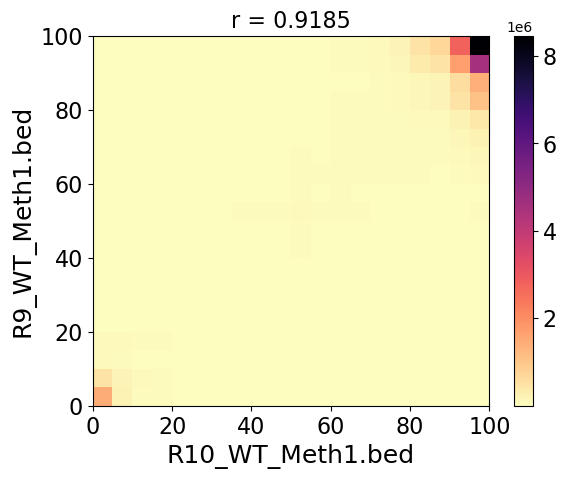

<Figure size 500x500 with 0 Axes>

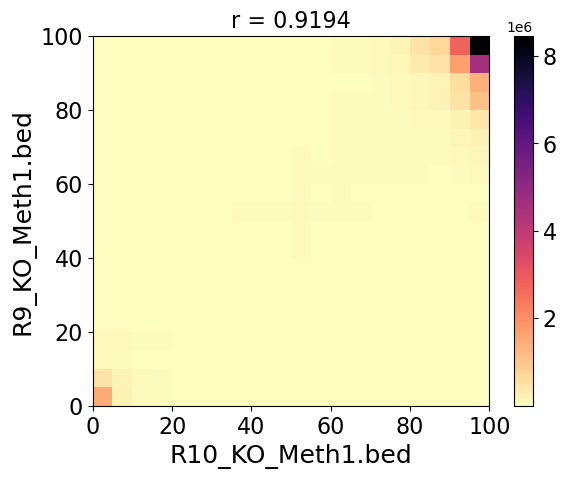

In [ ]:
# Figure 5 and finding sites unique to original calculation 

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import polars as pl
import itertools


# Method 1 or Method 2

method = 1 #Toggle this to 2 to do the other method
min_coverage = 10

files = f[method-1]

for f1, f2 in (itertools.combinations(files, 2)):
    # BED file 1
    df1 = pl.read_csv(f1, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_left", "STR_Percentage_left"], has_header=False)
    # BED file 2
    df2 = pl.read_csv(f2, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_right", "STR_Percentage_right"], has_header=False)
    # Merge BED files
    df = df1.join(df2, on=["chr", "start", "end"], how="inner")
    del df1
    del df2
    #Filter for min_coverage parameter
    df = df.filter((pl.col("Coverage_left") > min_coverage) & (pl.col("Coverage_right") > min_coverage))
    for TYPE in ["Percentage"]:
        loop_df = df
        if TYPE == "Percentage":
            # set all NaNs to 0
            loop_df = loop_df.select(pl.col("chr"), pl.col("start"), pl.col("end"), (pl.col("STR_Percentage_left").str.replace(r"(?i)nan", "0")), (pl.col("STR_Percentage_right").str.replace(r"(?i)nan", "0")))
            loop_df = loop_df.select([pl.col("chr"), pl.col("start"), pl.col("end"), pl.col("STR_Percentage_left").cast(pl.Float64).alias("Percentage_left"), pl.col("STR_Percentage_right").cast(pl.Float64).alias("Percentage_right")])
        x = loop_df["Percentage_left"]
        y = loop_df["Percentage_right"]
        # Checking to see if it is a sample-wise comparison
        if ("WT" in f1 and "WT" in f2) or ("KO" in f1 and "KO" in f2):
            !mkdir -p meth0_unique
            _df.select(pl.col("chr"), pl.col("start"), pl.col("end"))
            _df.write_csv(f"meth0_unique/{os.basename(f1)[:-4]}_{os.basename(f2)[:-4]}_overlapMeth1.bed", separator = '\t', include_header = False)
            plt.figure(figsize=(5, 5))
            fig, ax = plt.subplots()
            # change log_norm variable to determine heatmap type
            h = ax.hist2d(a, b, density=False, bins=20, cmap="magma_r")
            ax.tick_params(axis='both', which='major', labelsize=16)
            cbar = fig.colorbar(h[3], ax=ax)
            cbar.ax.tick_params(labelsize=16)
            x = x.to_numpy()
            y = y.to_numpy()
            p_corr = (str(pearsonr(x, y)[0]))
            plt.title("r = " + p_corr[0:6], fontsize=16)
            plt.xlabel(os.basename(f1), fontsize=18)
            plt.ylabel(os.basename(f2), fontsize=18)
            plt.show()
            plt.close()


# Original Method

method = 0
min_coverage = 10

files = f[method-1]


for f1, f2 in (itertools.combinations(files, 2)):
    # BED file 1
    df1 = pl.read_csv(f1, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_left", "STR_Percentage_left"], has_header=False)
    # BED file 2
    df2 = pl.read_csv(f2, separator="\t", columns=[0, 1, 2, 9, 10], new_columns=["chr", "start", "end", "Coverage_right", "STR_Percentage_right"], has_header=False)
    # Merge BED files
    df = df1.join(df2, on=["chr", "start", "end"], how="inner")
    del df1
    del df2
    #Filter for min_coverage parameter
    df = df.filter((pl.col("Coverage_left") > min_coverage) & (pl.col("Coverage_right") > min_coverage))
    for TYPE in ["Percentage"]:
        loop_df = df
        if TYPE == "Percentage":
            # set all NaNs to 0
            loop_df = loop_df.select(pl.col("chr"), pl.col("start"), pl.col("end"), (pl.col("STR_Percentage_left").str.replace(r"(?i)nan", "0")), (pl.col("STR_Percentage_right").str.replace(r"(?i)nan", "0")))
            loop_df = loop_df.select([pl.col("chr"), pl.col("start"), pl.col("end"), pl.col("STR_Percentage_left").cast(pl.Float64).alias("Percentage_left"), pl.col("STR_Percentage_right").cast(pl.Float64).alias("Percentage_right")])
        x = loop_df["Percentage_left"]
        y = loop_df["Percentage_right"]
        # Checking to see if it is a sample-wise comparison
        if ("WT" in f1 and "WT" in f2) or ("KO" in f1 and "KO" in f2):
            _df.select(pl.col("chr"), pl.col("start"), pl.col("end"))
            _df.write_csv(f"meth0_unique/{os.basename(f1)[:-4]}_{os.basename(f2)[:-4]}_overlapMeth0.bed", separator = '\t', include_header = False)
            plt.figure(figsize=(5, 5))
            fig, ax = plt.subplots()
            # change log_norm variable to determine heatmap type
            h = ax.hist2d(a, b, density=False, bins=20, cmap="magma_r")
            ax.tick_params(axis='both', which='major', labelsize=16)
            cbar = fig.colorbar(h[3], ax=ax)
            cbar.ax.tick_params(labelsize=16)
            x = x.to_numpy()
            y = y.to_numpy()
            p_corr = (str(pearsonr(x, y)[0]))
            plt.title("r = " + p_corr[0:6], fontsize=16)
            plt.xlabel(os.basename(f1), fontsize=18)
            plt.ylabel(os.basename(f2), fontsize=18)
            plt.show()
            plt.close()

# Finding sites unique to the modbam2bed calculation at a coverage of 10 (uncomment below lines and ensure you have bedtools installed)                
# !bedtools intersect -v -a meth0_unique/*WT*overlapMeth0.bed -b meth0_unique/*WT*overlapMeth0.bed > meth0_unique/WT_meth0.bed
# !bedtools intersect -v -a meth0_unique/*KO*overlapMeth0.bed -b meth0_unique/*KO*overlapMeth1.bed > meth0_unique/KO_meth0.bed

shape: (11_420_965, 5)
┌──────┬──────────┬──────────┬───────┬────────┐
│ chr  ┆ start    ┆ end      ┆ R9 WT ┆ R10 WT │
│ ---  ┆ ---      ┆ ---      ┆ ---   ┆ ---    │
│ str  ┆ i64      ┆ i64      ┆ f64   ┆ f64    │
╞══════╪══════════╪══════════╪═══════╪════════╡
│ chr1 ┆ 10855    ┆ 10856    ┆ 88.89 ┆ 100.0  │
│ chr1 ┆ 10930    ┆ 10931    ┆ 100.0 ┆ 100.0  │
│ chr1 ┆ 10931    ┆ 10932    ┆ 80.0  ┆ 66.67  │
│ chr1 ┆ 10933    ┆ 10934    ┆ 100.0 ┆ 100.0  │
│ chr1 ┆ 10934    ┆ 10935    ┆ 91.67 ┆ 100.0  │
│ …    ┆ …        ┆ …        ┆ …     ┆ …      │
│ chrY ┆ 56883117 ┆ 56883118 ┆ 77.78 ┆ 50.0   │
│ chrY ┆ 56883118 ┆ 56883119 ┆ 53.85 ┆ 100.0  │
│ chrY ┆ 56883503 ┆ 56883504 ┆ 75.0  ┆ 42.86  │
│ chrY ┆ 56883504 ┆ 56883505 ┆ 40.0  ┆ 80.0   │
│ chrY ┆ 56883652 ┆ 56883653 ┆ 50.0  ┆ 100.0  │
└──────┴──────────┴──────────┴───────┴────────┘


<Figure size 500x500 with 0 Axes>

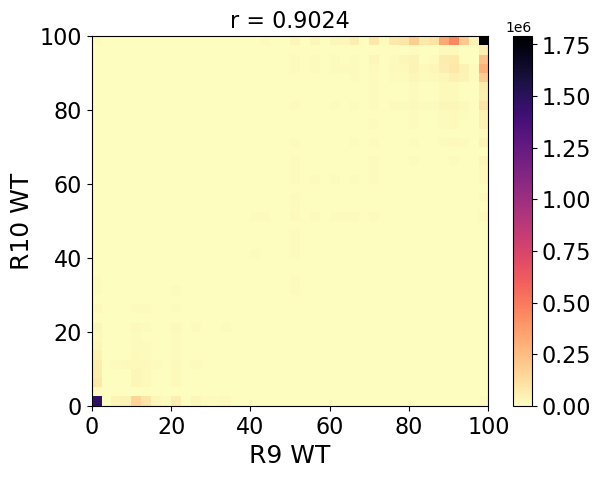

shape: (8_443_571, 5)
┌──────┬──────────┬──────────┬───────┬────────┐
│ chr  ┆ start    ┆ end      ┆ R9 KO ┆ R10 KO │
│ ---  ┆ ---      ┆ ---      ┆ ---   ┆ ---    │
│ str  ┆ i64      ┆ i64      ┆ f64   ┆ f64    │
╞══════╪══════════╪══════════╪═══════╪════════╡
│ chr1 ┆ 10930    ┆ 10931    ┆ 83.33 ┆ 85.71  │
│ chr1 ┆ 10931    ┆ 10932    ┆ 100.0 ┆ 100.0  │
│ chr1 ┆ 10933    ┆ 10934    ┆ 100.0 ┆ 100.0  │
│ chr1 ┆ 10934    ┆ 10935    ┆ 73.53 ┆ 100.0  │
│ chr1 ┆ 11166    ┆ 11167    ┆ 100.0 ┆ 100.0  │
│ …    ┆ …        ┆ …        ┆ …     ┆ …      │
│ chrY ┆ 56886822 ┆ 56886823 ┆ 58.82 ┆ 30.0   │
│ chrY ┆ 56886876 ┆ 56886877 ┆ 81.25 ┆ 90.0   │
│ chrY ┆ 56886893 ┆ 56886894 ┆ 77.27 ┆ 100.0  │
│ chrY ┆ 56886944 ┆ 56886945 ┆ 100.0 ┆ 100.0  │
│ chrY ┆ 56886954 ┆ 56886955 ┆ 66.67 ┆ 60.0   │
└──────┴──────────┴──────────┴───────┴────────┘


<Figure size 500x500 with 0 Axes>

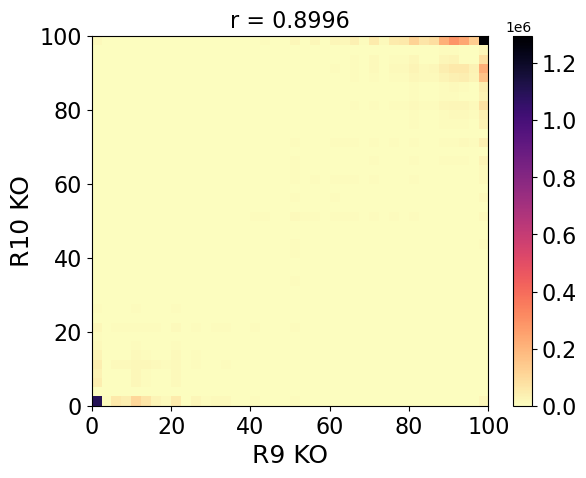

In [40]:
# Figure 6

import os.path as os

log_norm = "yes"

def plot_corr(_f):
    samp = os.basename(_f)[0:2]
    _df = pl.read_csv(_f, separator = '\t', new_columns = ["chr", "start", "end", f"R9 {samp}", f"R10 {samp}"], has_header = False)
    print(_df)
    x = _df[f"R9 {samp}"]
    y = _df[f"R10 {samp}"]
    b_ = [40]
    for b in b_:
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots()
        if log_norm == "yes":
            h_ = ax.hist2d(x, y, norm=mpl.colors.LogNorm(), density=False, bins=b, cmap="magma_r")
            cbar = fig.colorbar(h_[3], ax=ax)
        else:
            h = ax.hist2d(x, y, density=False, bins=b, cmap="magma_r")
            cbar = fig.colorbar(h[3], ax=ax)
        ax.tick_params(axis='both', which='major', labelsize=16)
        cbar.ax.tick_params(labelsize=16)
        if b == b_[0]:
            x = x.to_numpy()
            y = y.to_numpy()
            p_corr = (str(pearsonr(x, y)[0]))
        plt.title("r = " + p_corr[0:6], fontsize=16)
        plt.xlabel(f"R9 {samp}", fontsize=18)
        plt.ylabel(f"R10 {samp}", fontsize=18)
        plt.show()
fs = ["./meth0_unique/WT_meth0.bed", "./meth0_unique/KO_meth0.bed"]
for f in fs:
    plot_corr(f)